### ORIE 6750 Homework 4 Question 1
Best arm identification with normally distributed noise

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time

In [3]:
# regular bellman recursion -- parameters

K = 2  # two arms
R = 3  # upper/lower bound for truncating the real line
M = 100  # number of buckets for discretizing the truncated real line
delta = 2*R/M  # bucket size
mus = np.linspace(-R, R, M+1) # nodes

# initialize array for belief state
B = np.zeros((K,2))

In [25]:
def compute_likelihood(j, h, target_j, mus):
    """
    INPUT: 
    (j,h): current belief about the arm
    target_j: bucket of target posterior mean
    OUTPUT:
    the likelihood, given the current belief, that we observe a y-value with which we update
    our belief state to fall into the target bucket
    """
    M = len(mus)
    beta = (h+1) / (h+2)
    y_lower = (mus[target_j] - beta*mus[j]) / (1 - beta)
    y_upper = (mus[target_j] + delta - beta*mus[j]) / (1 - beta)
    
    integrand = lambda theta, y_lower, y_upper, target_j, h: \
                    (norm.cdf(y_upper-theta) - norm.cdf(y_lower-theta)) \
                    * np.exp(-(h+1)/2*(theta-mus[target_j])**2)
    integral = quad(integrand, -np.inf, np.inf, args = (y_lower, y_upper, target_j, h))[0]
    
    return np.sqrt((h+1)/(2*np.pi)) * integral
    
    

In [114]:
def compute_likelihood_array(H, M):
    
    print('Computing likelihood array for horizon '+ str(H))
    t = time.time()
    
    likelihood = np.zeros((M+1, H+1, M+1))

    for j in range(M+1):
        for h in range(H+1):
            for target_j in range(M+1):
                likelihood[j,h,target_j] = compute_likelihood(j, h, target_j, mus)
    
    for j in range(M+1):
        for h in range(H+1):
            norm = np.sum([likelihood[j, h, t_j] for t_j in range(101)])
            for t_j in range(M+1):
                likelihood[j, h, t_j] = likelihood[j, h, t_j]/norm
    
    print('Finished computing likelihood array for horizon ' + str(H) + ' in '\
          + str(time.time()-t)+ ' seconds')
    
    return likelihood

In [67]:
# check probability conservation
np.sum([likelihood[10, 2, j] for j in range(101)])

1.0

In [98]:
def compute_optimal_policy(H, M, likelihood, R=3):
    
    """Given horizon, discretization number, likelihood,
    find value function and optimal action array
    """
    
    print('Computing optimal policy for horizon '+ str(H))
    
    V = np.zeros((H+1, M+1, H+1, M+1, H+1))
    X = np.zeros((H, M+1, H+1, M+1, H+1))
    
    for j1 in range(M+1):
        for h1 in range(H+1):
            for j2 in range(M+1):
                for h2 in range(H+1):
                    V[0,j1,h1,j2,h2] = np.amax([mus[j1], mus[j2]])
    
    for step in range(1, H+1):

        print('time period '+str(step))

        Q = np.zeros((K, M+1, H+1, M+1, H+1))

        # loop over all possible belief states

        t = time.time()

        for j_fix in range(M+1):
            for h_fix in range(H):
                for j in range(M+1):
                    for h in range(H):

                        # loop over reachable target buckets

                        for target_j in range(M):

                            # if pull arm 1:
                            Q[0,j,h,j_fix,h_fix] += V[step-1,target_j,h+1,j_fix,h_fix] \
                                                            * likelihood[j, h, target_j]
                            # if pull arm 2:
                            Q[1,j_fix,h_fix,j,h] += V[step-1,j_fix,h_fix,target_j,h+1] \
                                                            * likelihood[j, h, target_j]

        print('Q factors computed in ' + str(time.time()-t)+ ' seconds')

        for j1 in range(M+1):
            for h1 in range(H+1):
                for j2 in range(M+1):
                    for h2 in range(H+1):

                        # take larger Q-factor and store as value
                        V[step,j1,h1,j2,h2] = np.amax([Q[0,j1,h1,j2,h2], Q[1,j1,h1,j2,h2]])

                        # record the arm to pull
                        X[step-1,j1,h1,j2,h2] = np.argmax([Q[0,j1,h1,j2,h2], Q[1,j1,h1,j2,h2]])


    return V, X

In [129]:
def simulate_optimal_policy(H, X, K=2, N_sim=1000,R=3,M=100):
    """
    Input: horizon H, optimal policy array X, number of arms, number of simulations
    """
    
    print("Simulating for horizon = "+str(H))
    
    delta = 2*R/M # bucket size
    values = 0
    
    for n in range(N_sim):
                
        B = np.zeros((K,2))
        theta = np.random.normal(0,1,K)
        
        for step in range(H):
        
            pull = int(X[step, int(np.amin([np.floor((B[0,0]+R)/delta), M])), int(B[0,1]), \
                     int(np.amin([np.floor((B[1,0]+R)/delta), M])), int(B[1,1])])

            Y = np.random.normal(theta[pull], 1)

            beta_pull = (B[pull,1]+1) / (B[pull,1]+2)
            B[pull,0] = B[pull,0]*beta_pull + (1-beta_pull)*Y
            B[pull,1] += 1

        values += np.max([B[0,0], B[1,0]])
    
    return values / N_sim

In [119]:
likelihood=compute_likelihood_array(10,100)

np.save('likelihood_horizon10',likelihood)

#likelihood = np.load('likelihood_horizon10.npy')

Computing likelihood array for horizon 10
Finished computing likelihood array for horizon 10 in 3492.4383459091187 seconds


In [135]:
#values_compare = np.zeros((10,2))

for h in range(10):
    H=h+1
    #likelihood = compute_likelihood_array(H, 100)
    V,X = compute_optimal_policy(H, 100, likelihood)
    values_compare[h, 0] = V[H, 50, 0, 50, 0]
    values_compare[h, 1] = simulate_optimal_policy(H, X)

Computing optimal policy for horizon 10
time period 1
Q factors computed in 245.0888111591339 seconds
time period 2
Q factors computed in 242.63385772705078 seconds
time period 3
Q factors computed in 303.609756231308 seconds
time period 4
Q factors computed in 289.39653730392456 seconds
time period 5
Q factors computed in 316.2666118144989 seconds
time period 6
Q factors computed in 279.32799220085144 seconds
time period 7
Q factors computed in 243.57543301582336 seconds
time period 8
Q factors computed in 292.1826012134552 seconds
time period 9
Q factors computed in 271.78053998947144 seconds
time period 10
Q factors computed in 256.71269607543945 seconds
Simulating for horizon = 10
Computing optimal policy for horizon 11
time period 1
Q factors computed in 317.46845412254333 seconds
time period 2
Q factors computed in 309.83038806915283 seconds
time period 3
Q factors computed in 315.5567169189453 seconds
time period 4
Q factors computed in 300.0435070991516 seconds
time period 5
Q 

IndexError: index 10 is out of bounds for axis 0 with size 10

In [136]:
values_compare

array([[0.49483695, 0.29698544],
       [0.67627377, 0.40182158],
       [0.7105858 , 0.43268482],
       [0.73394914, 0.44610925],
       [0.74485106, 0.46867454],
       [0.7519399 , 0.51265452],
       [0.75631845, 0.49909573],
       [0.75926993, 0.45809755],
       [0.76127031, 0.54079015],
       [0.76266791, 0.4903737 ]])

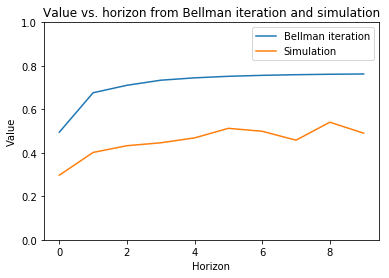

In [142]:
plt.plot(values_compare[:,0], label='Bellman iteration')
plt.plot(values_compare[:,1], label='Simulation')
plt.ylim(0,1)
plt.title('Value vs. horizon from Bellman iteration and simulation')
plt.xlabel('Horizon')
plt.ylabel('Value')
plt.legend()